In [1]:
# !pip uninstall torch torchvision torchaudio -y

In [2]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

In [3]:
# !pip install mne -q
# !pip install wandb -q
# !pip install tensorboard -q

In [4]:
import platform

# choose system according your current machine
# SYSTEM_NAME = "Windows"
# SYSTEM_NAME = "Colab"
# SYSTEM_NAME = "Kaggle"
SYSTEM_NAME = "Linux"

if SYSTEM_NAME == "Colab":
    from google.colab import drive
    drive.mount('/content/drive/')
    
print(SYSTEM_NAME)

Linux


# Constants and libraries

In [5]:
# Project folder
if SYSTEM_NAME == "Windows": PROJECT_FOLDER = ""
elif SYSTEM_NAME == "Colab": PROJECT_FOLDER = "drive/MyDrive/Colab Notebooks/Neuroimaging and ML Group/Autoencoders/"  
elif SYSTEM_NAME == "Kaggle": PROJECT_FOLDER = "/kaggle/"  
elif SYSTEM_NAME == "Linux": PROJECT_FOLDER = ""
else: raise ValueError("Unknown system name")
    
if SYSTEM_NAME in ["Windows", "Colab", "Linux"]: SRC_FOLDER = PROJECT_FOLDER
elif SYSTEM_NAME == "Kaggle": SRC_FOLDER = PROJECT_FOLDER + "input/eeg-age-prediction-utils/"
else: raise ValueError("Unknown system name")
    
if SYSTEM_NAME in ["Windows", "Colab", "Linux"]: OUTPUT_FOLDER = PROJECT_FOLDER
elif SYSTEM_NAME == "Kaggle": OUTPUT_FOLDER = PROJECT_FOLDER + "working/"
else: raise ValueError("Unknown system name")

print(f"{PROJECT_FOLDER = }")
print(f"{SRC_FOLDER = }")
print(f"{OUTPUT_FOLDER = }")
print()

# TUAB
if SYSTEM_NAME in ["Windows", "Colab", "Linux"]: TUAB_DIRECTORY = PROJECT_FOLDER + "Data/TUAB/"
elif SYSTEM_NAME == "Kaggle": TUAB_DIRECTORY = PROJECT_FOLDER + "input/tuab-age-prediction-60-s-all-records/TUAB/"
else: raise ValueError("Unknown system name")

if SYSTEM_NAME in ["Windows", "Linux", "Colab"]: TUAB_TRAIN = TUAB_DIRECTORY + "train/normal/01_tcp_ar/"
elif SYSTEM_NAME in ["Kaggle"]: TUAB_TRAIN = TUAB_DIRECTORY + "train/"
else: raise ValueError("Unknown system name")

if SYSTEM_NAME in ["Windows", "Linux", "Colab"]: TUAB_EVAL = TUAB_DIRECTORY + "eval/normal/01_tcp_ar/"
elif SYSTEM_NAME in ["Kaggle"]: TUAB_EVAL = TUAB_DIRECTORY + "eval/"
else: raise ValueError("Unknown system name")

print(f"{TUAB_DIRECTORY = }")
print(f"{TUAB_TRAIN = }")
print(f"{TUAB_EVAL = }")
print()

# Depression anonymized
if SYSTEM_NAME in ["Windows", "Linux", "Colab"]: DEPR_ANON_DIRECTORY = PROJECT_FOLDER + "Data/depression_anonymized/" #in microvolts
elif SYSTEM_NAME == "Kaggle": DEPR_ANON_DIRECTORY = PROJECT_FOLDER + "input/depression-anonymized/"
else: raise NotImplementedError 
print(f"{DEPR_ANON_DIRECTORY = }")
print()

#Inhouse dataset
if SYSTEM_NAME in ["Windows", "Linux", "Colab"]: INHOUSE_DIRECTORY = PROJECT_FOLDER + "Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/"
elif SYSTEM_NAME == "Kaggle": INHOUSE_DIRECTORY = PROJECT_FOLDER + "input/inhouse-dataset/"
else: raise NotImplementedError
print(f"{INHOUSE_DIRECTORY = }")
print()

# Constants
SAMPLING_FREQUENCY = 250 #Hz
L_FREQ = 0.1 #Hz
H_FREQ = 30 #Hz
AMPLITUDE_THRESHOLD = 0.005 #V
STD_THRESHOLD = 5
TRANSIENT_STD_THRESHOLD = 3
SEED = 42

PROJECT_FOLDER = ''
SRC_FOLDER = ''
OUTPUT_FOLDER = ''

TUAB_DIRECTORY = 'Data/TUAB/'
TUAB_TRAIN = 'Data/TUAB/train/normal/01_tcp_ar/'
TUAB_EVAL = 'Data/TUAB/eval/normal/01_tcp_ar/'

DEPR_ANON_DIRECTORY = 'Data/depression_anonymized/'

INHOUSE_DIRECTORY = 'Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/'



In [6]:
import warnings
warnings.simplefilter("ignore")

import os
import pickle
from tqdm.auto import tqdm as tqdm_auto
import sys
sys.path.append(SRC_FOLDER)
from utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation', html='jshtml')

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

import wandb
!wandb login 1b8e8dc9dcf1a34397a04197c4826d3fe7441dae

import mne

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
cuda


In [7]:
%load_ext autoreload
%autoreload 1
%aimport utils

from utils.models_evaluation import evaluateClassifier, evaluateRegressor
from utils.data_reading import DataReader
from utils.plotting import dataset_hists, plotData
from utils.dataset import InMemoryDataset
from utils.logger import Logger

from models.modules import encoder_conv, decoder_conv, encoder_conv4, decoder_conv4
from models.VAE import VAE, BetaVAE_H, BetaVAE_B
from models.AE import AE, AE_framework
from models.UNet import UNet

# Data preview

In [8]:
def tree(data_dir, n_files=2):
    for dir, _, filenames in os.walk(data_dir):
        print(dir)
        for filename in filenames[:n_files]:
            print(os.path.join(dir, filename))

### TUAB

In [9]:
tree(TUAB_DIRECTORY)

Data/TUAB/
Data/TUAB/AAREADME.txt
Data/TUAB/train
Data/TUAB/train/normal
Data/TUAB/train/normal/01_tcp_ar
Data/TUAB/train/normal/01_tcp_ar/aaaaajab_s002_t000_targets.npy
Data/TUAB/train/normal/01_tcp_ar/aaaaaebo_s003_t001_targets.npy
Data/TUAB/eval
Data/TUAB/eval/normal
Data/TUAB/eval/normal/01_tcp_ar
Data/TUAB/eval/normal/01_tcp_ar/aaaaajnu_s001_t000_chunks_fz_cz_pz_3x124.npy
Data/TUAB/eval/normal/01_tcp_ar/aaaaamfu_s001_t000_chunks_fz_cz_pz_3x124.npy


In [10]:
# raw = mne.io.read_raw_edf(TUAB_TRAIN + "/aaaaaaff_s002_t000.edf", preload=False)
# print(raw.ch_names, "\nDuration:", raw.times[-1]/60, "m")
# display(raw.info)
# raw.plot(n_channels=21, duration=100, scalings=100e-6, start=20);#.set_size_inches(5, 5, forward=True)

### Depression anonymized

In [11]:
tree(DEPR_ANON_DIRECTORY)

Data/depression_anonymized/
Data/depression_anonymized/chunks_fz_cz_pz_3x124_healthy.npy
Data/depression_anonymized/targets.npy
Data/depression_anonymized/epoch_3
Data/depression_anonymized/epoch_3/17503e670d10b4eb.csv
Data/depression_anonymized/epoch_3/78357506dc397116.csv
Data/depression_anonymized/epoch_1
Data/depression_anonymized/epoch_1/3bde43ff334f2463.csv
Data/depression_anonymized/epoch_1/7bf558baa390813a.csv
Data/depression_anonymized/epoch_1/.ipynb_checkpoints
Data/depression_anonymized/epoch_1/.ipynb_checkpoints/0046a00e1f0406c0-checkpoint.csv
Data/depression_anonymized/epoch_1/.ipynb_checkpoints/path_file-checkpoint.csv


### Inhouse dataset

In [12]:
tree(INHOUSE_DIRECTORY)

Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/
Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/path_file.csv
Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/._.DS_Store
Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/MDD
Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/MDD/clean_S1421.csv
Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/MDD/clean_S1082.csv
Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/Health
Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/Health/clean_S1211.csv
Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/Health/clean_S271.csv


# Data preprocessing and saving

### TUAB

In [13]:
# for directory, _, file_names in os.walk(TUAB_DIRECTORY):
#     print(directory)
#     for file_name in file_names:
#         if ".csv_chunks_fz_cz_pz_3x124.npy" in file_name or ".csv_targets.npy" in file_name:
#             os.remove(os.path.join(directory, file_name))

In [14]:
# def readCsv(file_name):
#     file_obj = open(file_name, "r")
#     age = int(file_obj.readline()[8:-1])
#     data = file_obj.readlines()
#     file_obj.close()
#     data[0] = data[0].replace("# ", "")
#     processed_file_name = str(age) + ".csv"
#     processed_file_obj = open(processed_file_name, "w")
#     processed_file_obj.writelines(data)
#     df = pd.read_csv(processed_file_name)
#     processed_file_obj.close()
#     os.remove(processed_file_name)
#     return df, age

# def df2edf(df, sfreq=SAMPLING_FREQUENCY):
#     ch_names = df.columns.to_list()
#     ch_types = ['eeg'] * len(ch_names)
#     info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sfreq)
#     return mne.io.RawArray(df[ch_names].to_numpy(copy=True).T / 1e6, info, verbose=False) #data in microvolts

# def selectChunks(df, ch_names, chunk_duration=124, n_chunks_max=None):
#     chunks = []
#     start_idx = 0
#     end_idx = start_idx + chunk_duration

#     while end_idx <= df.shape[0]:
#         if n_chunks_max != None and len(chunks) >= n_chunks_max:
#             break

#         chunk = df.iloc[start_idx:end_idx]
#         if len(chunk) != chunk_duration:
#             print(f"WARNING: chunk shape = {chunk.shape}")
#             start_idx = end_idx
#             end_idx += chunk_duration
#             continue

#         #std = 5 threshold
#         if chunk[ch_names].to_numpy().std() >= 5:
#             start_idx = end_idx
#             end_idx += chunk_duration
#             continue

#         # std t, t+1 threshold
#         # drop = False
#         # for col in chunk[ch_names]:
#         #     timeseries = chunk[col].to_numpy()
#         #     for i in range(len(timeseries) - 1):
#         #         if np.std([timeseries[i], timeseries[i + 1]]) >= 3:
#         #             drop = True
#         #             break
#         #     if drop:
#         #         break
#         # if drop:
#         #     continue

#         chunks.append(chunk)
#         start_idx = end_idx
#         end_idx += chunk_duration

#     return chunks

# def getAge(file_name):
#     f = open(file_name, "r", encoding="utf-8")
#     try:
#         buffer = "1234"
#         while buffer != "Age:":
#             buffer = buffer[1:] + f.read(1)

#         age = f.read(2)
#         f.close()
#         return int(age)

#     except (UnicodeDecodeError, KeyboardInterrupt, ValueError) as error:
#         f.close()
#         return "error"

# def preprocessRecord(
#         file_name,
#         verbose=False,
#         channels_to_drop=['EEG ROC-REF', 'EEG LOC-REF', 'EEG EKG1-REF', 'PHOTIC-REF', 'IBI', 'BURSTS', 'SUPPR'],
#         sfreq=125,
#         l_freq=L_FREQ,
#         h_freq=H_FREQ,
#         ampl_thresh=AMPLITUDE_THRESHOLD
#     ):
#     #average reference, filtration
#     raw = mne.io.read_raw_edf(file_name, preload=False, verbose=verbose) #data in microvolts
#     raw = raw.drop_channels(channels_to_drop, on_missing="warn")
#     raw = raw.resample(sfreq, npad='auto')
#     raw, _ = mne.set_eeg_reference(raw, ref_channels='average', verbose=verbose) #average reference
#     raw.filter(l_freq=l_freq, h_freq=h_freq, method='iir', verbose=verbose) #filtration
#     df = raw.to_data_frame() #in microvolts
#     ch_names = raw.ch_names

#     #clipping
#     df.loc[:, ch_names].clip(-ampl_thresh, ampl_thresh, inplace=True)

#     #normalization
#     df.loc[:, ch_names] = (df[ch_names] - df[ch_names].mean())/df[ch_names].std()

#     return df, ch_names #time is also among columns

# def processDirectoryData(
#         directory,
#         picked_channels,
#         n_files=None,
#         file_type = "edf",
#         chunks_file_suffix = "_chunks_fz_cz_pz_3x124",
#         targets_file_suffix = "_targets",
#         is_save = True,
#         is_return = True,
#         force_recompute = False,
#         **kwargs):
#     n_files_read = 0
#     n_files_passed = 0

#     if n_files is not None:
#         file_names = os.listdir(directory)[:n_files]
#     else:
#         file_names = os.listdir(directory)

#     if is_return:
#         bunch_of_chunks_list = []
#         bunch_of_targets_list = []

#     for file_name in tqdm_auto(file_names):
#         if fileExtension(file_name) == file_type and \
#             (force_recompute or \
#              not (os.path.exists(directory + fileName(file_name) + chunks_file_suffix + ".npy") and \
#                   os.path.exists(directory + fileName(file_name) + targets_file_suffix + ".npy")\
#                  )\
#             ):
#             chunks_list = []
#             targets_list = []

#             age = getAge(directory + file_name)
#             if age == "error":
#                 n_files_passed += 1
#                 print(f"File {file_name} was passed, passed files: {n_files_passed}, read files: {n_files_read}")
#                 continue
#             n_files_read += 1

#             df, ch_names = preprocessRecord(directory + file_name)
#             chunks_from_record = selectChunks(df, ch_names, **kwargs)
#             for chunk in chunks_from_record:
#                 image = chunk[picked_channels].to_numpy().T
#                 chunks_list.append(image)
#                 targets_list.append(age)

#             chunks = np.array(chunks_list)
#             targets = np.array(targets_list)

#             if is_return:
#                 bunch_of_chunks_list.append(chunks)
#                 bunch_of_targets_list.append(targets)

#             if is_save:
#                 np.save(directory + fileName(file_name) + chunks_file_suffix, chunks)
#                 np.save(directory + fileName(file_name) + targets_file_suffix, targets)

#     print(f"Read files: {n_files_read}, passed files: {n_files_passed}")
#     if is_return:
#         return np.concatenate(bunch_of_chunks_list), np.concatenate(bunch_of_targets_list)


In [15]:
# picked_channels = ['EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF']
# chunks_file_name = "chunks_fz_cz_pz_3x124"
# targets_file_name = "targets"
# for directory in [TUAB_TRAIN, TUAB_EVAL]:
#     chunks, targets = processDirectoryData(
#         directory,
#         picked_channels,
#         n_chunks_max=60,
#         force_recompute=True,
#         chunks_file_suffix="_"+chunks_file_name,
#         targets_file_suffix="_"+targets_file_name
#     )
#     np.save(directory + chunks_file_name, chunks)
#     np.save(directory + targets_file_name, targets)

In [16]:
#concatenate .npy files together
# for directory in [TUAB_TRAIN, TUAB_EVAL]:
#     print(directory)
#     chunks_list = []
#     targets_list = []
#     for file_name in [directory + chunks_file_name + ".npy", directory + targets_file_name + ".npy"]: #delete only files with all chunks
#         if os.path.exists(file_name):
#             os.remove(file_name)

#     for i, file_name in enumerate(tqdm_auto(os.listdir(directory))): #iterate through files from every csv file
#         if chunks_file_name in file_name or targets_file_name in file_name:
#             data = np.load(directory + file_name)
#             if targets_file_name in file_name:
#                 targets_list.append(data)
#             else:
#                 chunks_list.append(data)

#     chunks = np.array(chunks_list).reshape(-1, 1, 3, 124)
#     targets = np.array(targets_list).reshape(-1)
#     print("Chunks:", chunks.shape, "targets:", targets.shape)
#     prefix = "train_" if directory == TUAB_TRAIN else "eval_"
#     np.save(directory + "../" + prefix + chunks_file_name, chunks)
#     np.save(directory + "../" + prefix + targets_file_name, targets)

### Depression anonymized

In [17]:
# def pickChunks(df, ch_names):
#     chunks = []
#     start_idx = 0
#     chunk_duration = 124
#     end_idx = start_idx + chunk_duration

#     while end_idx <= df.shape[0]:
#         chunk = df.iloc[start_idx:end_idx]
#         if len(chunk) != chunk_duration:
#             print(f"WARNING: chunk shape = {chunk.shape}")
#             start_idx = end_idx
#             end_idx += chunk_duration
#             continue

#         #std = 5 threshold
#         if chunk[ch_names].to_numpy().std() >= 5:
#             start_idx = end_idx
#             end_idx += chunk_duration
#             continue

#         # std t, t+1 threshold
#         # drop = False
#         # for col in chunk[ch_names]:
#         #     timeseries = chunk[col].to_numpy()
#         #     for i in range(len(timeseries) - 1):
#         #         if np.std([timeseries[i], timeseries[i + 1]]) >= 3:
#         #             drop = True
#         #             break
#         #     if drop:
#         #         break
#         # if drop:
#         #     continue

#         chunks.append(chunk)
#         start_idx = end_idx
#         end_idx += chunk_duration

#     return chunks


# def processPatientData(df):
#     #average reference, filtration
#     ch_names = df.columns.to_list()[1:] #delete 'time' #['t6', 't4', 'o1', 'f8', 'p4', 'c4', 't3', 'f7', 'f3', 'o2', 'f4', 'c3', 'p3', 't5', 'cz', 'fp1', 'fp2', 'pz', 'fz']
#     ch_types = ['eeg'] * 19
#     info = mne.create_info(ch_names, ch_types=ch_types, sfreq=125)
#     raw = mne.io.RawArray(df[ch_names].to_numpy(copy=True).T / 1e6, info, verbose=False) #data in microvolts
#     raw, _ = mne.set_eeg_reference(raw, ref_channels='average', verbose=False) #average reference
#     raw.filter(l_freq=L_FREQ, h_freq=H_FREQ, method='iir', verbose=False) #filtration
#     df = raw.to_data_frame() #in microvolts

#     #clipping
#     df.loc[:, ch_names].clip(-AMPLITUDE_THRESHOLD, AMPLITUDE_THRESHOLD, inplace=True)

#     #normalization
#     df.loc[:, ch_names] = (df[ch_names] - df[ch_names].mean())/df[ch_names].std()

#     return pickChunks(df, ch_names)

In [18]:
# epoch_folders = ["epoch_1/", "epoch_3/"]
# picked_channels = ["fz", "cz", "pz"]
# chunks_list = []

# for epoch_folder in epoch_folders:
#     print(epoch_folder)
#     data_epoch_descr = pd.read_csv(DEPR_ANON_DIRECTORY + epoch_folder + "path_file.csv")
#     data_epoch_list = readDataExt_one(DEPR_ANON_DIRECTORY + epoch_folder, exclude={"path_file.csv"}, is_list=True)

#     for df in tqdm(data_epoch_list):
#         # if data_epoch_descr[data_epoch_descr["fn"] == df['file_name'].iloc[0]].iloc[0]['target'] == 1: #take only healthy
#         #     continue

#         # print(df['file_name'][0])
#         chunks_from_patient = processPatientData(df.drop(['file_name'], axis=1))
#         file_mask = data_epoch_descr["fn"] == df['file_name'].iloc[0]
#         target = data_epoch_descr[file_mask].iloc[0]['target']

#         for chunk in chunks_from_patient:
#             image = chunk[picked_channels].to_numpy().T
#             chunks_list.append({
#                 "chunk": image,
#                 "target": target,
#                 "patient": df['file_name'].iloc[0]
#             })

# print("\nChunks shape:", chunks_list[0]["chunk"].shape, "length:", len(chunks_list))

In [19]:
# with open(DEPR_ANON_DIRECTORY + "dataset.pkl", "wb") as f:
#     pickle.dump(chunks_list, f)

### Inhouse dataset

In [20]:
# def pickChunks(df, ch_names, n_samples_per_chunk=124):
#     chunks = []
#     start_idx = 0
#     chunk_duration = n_samples_per_chunk
#     end_idx = start_idx + chunk_duration

#     while end_idx <= df.shape[0]:
#         chunk = df.iloc[start_idx:end_idx]
#         if len(chunk) != chunk_duration:
#             print(f"WARNING: chunk shape = {chunk.shape}")
#             start_idx = end_idx
#             end_idx += chunk_duration
#             continue

#         #std = 5 threshold
#         if chunk[ch_names].to_numpy().std() >= 5:
#             start_idx = end_idx
#             end_idx += chunk_duration
#             continue

#         # std t, t+1 threshold
#         # drop = False
#         # for col in chunk[ch_names]:
#         #     timeseries = chunk[col].to_numpy()
#         #     for i in range(len(timeseries) - 1):
#         #         if np.std([timeseries[i], timeseries[i + 1]]) >= 3:
#         #             drop = True
#         #             break
#         #     if drop:
#         #         break
#         # if drop:
#         #     continue

#         chunks.append(chunk)
#         start_idx = end_idx
#         end_idx += chunk_duration

#     return chunks


# def processPatientData(df, sfreq=125, sfreq_source=500):
#     #average reference, filtration
#     ch_names = df.columns.to_list()[1:] #delete 'time' #['Fp1', 'Fp2', 'F3', 'F4', 'Fz', 'C3', 'C4', 'Cz', 'P3', 'P4', 'Pz', 'O1', 'O2', 'F7', 'F8']
#     ch_types = ['eeg'] * len(ch_names)
#     info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sfreq_source)
#     raw = mne.io.RawArray(df[ch_names].to_numpy(copy=True).T / 1e6, info, verbose=False) #data in microvolts
#     raw, _ = mne.set_eeg_reference(raw, ref_channels='average', verbose=False) #average reference
#     raw.filter(l_freq=L_FREQ, h_freq=H_FREQ, method='iir', verbose=False) #filtration
#     raw = raw.resample(sfreq, npad='auto')
#     df = raw.to_data_frame() #in microvolts

#     #clipping
#     df.loc[:, ch_names].clip(-AMPLITUDE_THRESHOLD, AMPLITUDE_THRESHOLD, inplace=True)

#     #normalization
#     df.loc[:, ch_names] = (df[ch_names] - df[ch_names].mean())/df[ch_names].std()

#     return pickChunks(df, ch_names, 124)

In [21]:
# data_folders = ["MDD", "Health"]
# picked_channels = ["Fz", "Cz", "Pz"]
# chunks_list = []

# data_epoch_descr = pd.read_csv(os.path.join(INHOUSE_DIRECTORY, "path_file.csv")).drop(["Unnamed: 0"], axis="columns")
# data_epoch_descr["fn"] = data_epoch_descr["fn"].map(lambda x: x.split("/")[1])
# data_epoch_list = readDataExt_mul([os.path.join(INHOUSE_DIRECTORY, x) for x in data_folders], is_list=True)
# data_epoch_list_ = []
# for df_list in data_epoch_list: data_epoch_list_.extend(df_list)
# data_epoch_list = data_epoch_list_

# for df in tqdm(data_epoch_list):
#     chunks_from_patient = processPatientData(df.drop(['file_name', "Unnamed: 0"], axis=1))
#     file_mask = data_epoch_descr["fn"] == df['file_name'].iloc[0]
#     target = data_epoch_descr[file_mask].iloc[0]['target']

#     for chunk in chunks_from_patient:
#         image = chunk[picked_channels].to_numpy().T
#         chunks_list.append({
#             "chunk": image,
#             "target": target,
#             "patient": df['file_name'].iloc[0]
#         })

# print("\nChunks shape:", chunks_list[0]["chunk"].shape, "length:", len(chunks_list))

In [22]:
# with open(os.path.join(INHOUSE_DIRECTORY + "dataset.pkl"), "wb") as f:
#     pickle.dump(chunks_list, f)

# Data load


### TUAB

In [23]:
# from sklearn.model_selection import train_test_split

# chunks_train = np.load(TUAB_TRAIN + "chunks_fz_cz_pz_3x124.npy").reshape(-1, 1, 3, 124)
# targets_train = np.load(TUAB_TRAIN + "targets.npy")
# chunks_val_test = np.load(TUAB_EVAL + "chunks_fz_cz_pz_3x124.npy").reshape(-1, 1, 3, 124)
# targets_val_test = np.load(TUAB_EVAL + "targets.npy")
# chunks_val, chunks_test, targets_val, targets_test = train_test_split(chunks_val_test, targets_val_test, test_size=0.5, random_state=SEED, shuffle=False)
# print(chunks_train.shape, targets_train.shape, chunks_val.shape, targets_val.shape, chunks_test.shape, targets_test.shape)

### Depression anonimyzed

In [24]:
file = DEPR_ANON_DIRECTORY + "dataset.pkl"
train_set, val_set, test_set = DataReader(file).split()
chunks_train, chunks_val, chunks_test = train_set["chunk"], val_set["chunk"], test_set["chunk"]
targets_train, targets_val, targets_test = train_set["target"], val_set["target"], test_set["target"]


Chunks shape: (3, 124) , length: 10679 , keys: dict_keys(['chunk', 'target', 'patient'])
N patients = 178
Train=142, validation=18, test=18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10679/10679 [00:00<00:00, 34580.84it/s]

Train: 8519 (3, 124)
Validation: 1080 (3, 124)
Test: 1080 (3, 124)


### Inhouse dataset

In [25]:
# with open(INHOUSE_DIRECTORY + "dataset.pkl", "rb") as f:
#     chunks_list = pickle.load(f)
# print("\nChunks shape:", chunks_list[0]["chunk"].shape, "length:", len(chunks_list), "keys:", chunks_list[0].keys())

In [26]:
# from sklearn.model_selection import train_test_split
# from copy import deepcopy

# patients_targets = pd.DataFrame.from_records([{"patient": x["patient"], "target": x["target"]} for x in chunks_list]).drop_duplicates().reset_index(drop=True)
# print(f"N patients = {len(patients_targets)}")

# patients_train, patients_val_test = train_test_split(patients_targets, test_size=0.2, random_state=SEED, stratify=patients_targets["target"], shuffle=True)
# patients_val, patients_test = train_test_split(patients_val_test, test_size=0.5, random_state=SEED, stratify=patients_val_test["target"], shuffle=True)
# patients_train, patients_val, patients_test = patients_train["patient"].values, patients_val["patient"].values, patients_test["patient"].values
# print(f"Train={len(patients_train)}, validation={len(patients_val)}, test={len(patients_test)}")

# reset = {"chunk": [], "target": [], "patient": []}
# train_set, val_set, test_set = deepcopy(reset), deepcopy(reset), deepcopy(reset)

# for chunk in tqdm_auto(chunks_list):
#     patient_id = chunk["patient"]
#     was_added = False
#     for data_set, patients in zip([train_set, val_set, test_set], [patients_train, patients_val, patients_test]):
#         if patient_id in patients:
#             for tag in ["chunk", "target", "patient"]:
#                 data_set[tag].append(chunk[tag])
#                 was_added = True
        
#     if not was_added:
#         raise ValueError(f"Unexpected patient id {patient_id}")
    
# for data_set in [train_set, val_set, test_set]:
#     data_set["chunk"] = np.array(data_set["chunk"])
#     data_set["target"] = np.array(data_set["target"])

# print("Train:", len(train_set["chunk"]), train_set["chunk"][0].shape)
# print("Valitation:", len(val_set["chunk"]), val_set["chunk"][0].shape)
# print("Test:", len(test_set["chunk"]), test_set["chunk"][0].shape)

In [27]:
# chunks_train, chunks_val, chunks_test = train_set["chunk"], val_set["chunk"], test_set["chunk"]
# targets_train, targets_val, targets_test = train_set["target"], val_set["target"], test_set["target"]

#### For training on healthy only

In [28]:
# chunks_train_0 = chunks_train[np.where(targets_train == 0)]
# targets_train_0 = np.zeros(len(chunks_train_0))

# chunks_train = chunks_train_0
# targets_train = targets_train_0

# Data exploration

### TUAB

#### Targets

In [29]:
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
# ax[0].hist(targets_train);
# ax[0].set_title("Train");
# ax[1].hist(targets_val);
# ax[1].set_title("Validation");
# ax[2].hist(targets_test);
# ax[2].set_title("Test");
# plt.show();

#### Chunks

In [30]:
# for chunks in [chunks_train, chunks_val, chunks_test]:
#     chunks_minmax = []
#     for sample in chunks:
#         chunks_minmax.append((sample - sample.min())/(sample.max() - sample.min()))

#     print("Mean", np.array(chunks_minmax).mean(), "std", np.array(chunks_minmax).std())

In [31]:
# for chunks in [chunks_train, chunks_val, chunks_test]:
#     fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 2))
#     for i, ch in enumerate(np.moveaxis(chunks_train, [0, 1, 2, 3], [2, 1, 0, 3]).reshape([3, -1])):
#         ax[i].hist(ch, bins=50, range=[-5, 5])

### Depression anonymized

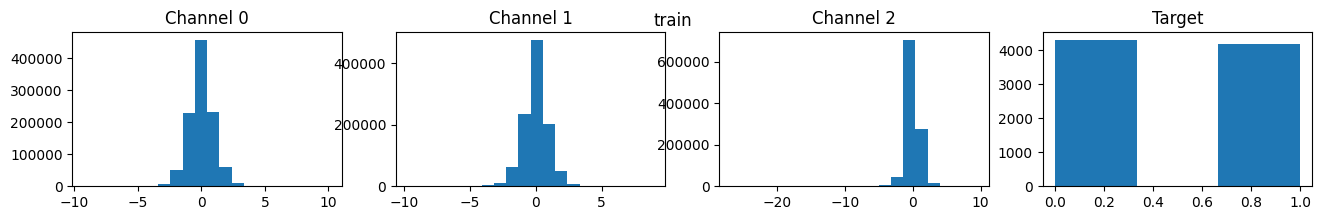

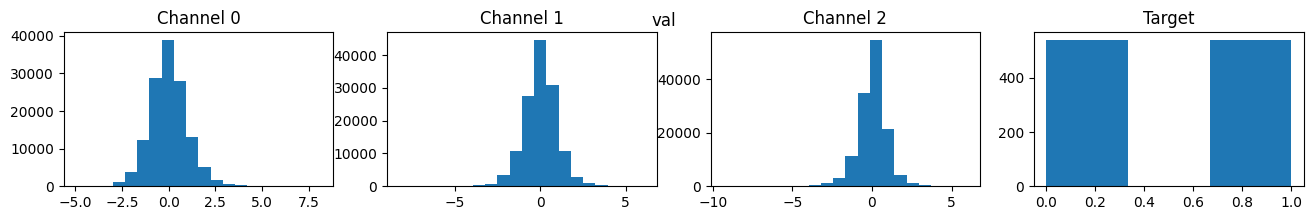

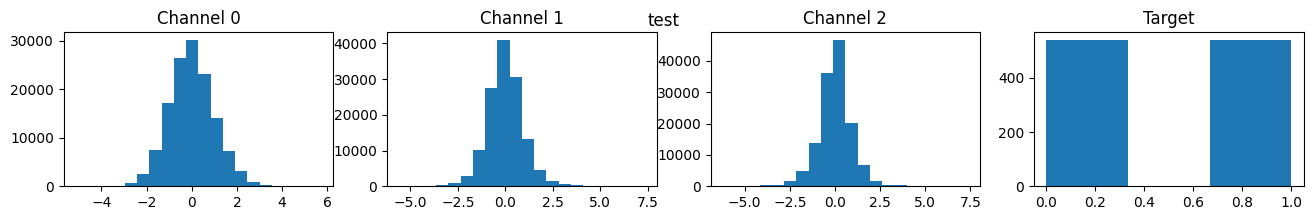

In [32]:
dataset_hists(train_set, val_set, test_set)

### Inhouse dataset

In [33]:
# for data_set in [train_set, val_set, test_set]:
#     fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 2))
#     for i in range(3): ax[i].hist(data_set["chunk"][:, i, :].flatten(), bins=20, range=(-5,5))
#     ax[3].hist(data_set["target"], bins=3)
#     plt.show()

# Train by hands

In [34]:
data_config = {
    "batch_size": 256,
    "num_workers": 0,
    "samples_shape": chunks_train[0].shape,
    "n_train_samples": len(chunks_train),
    "n_test_samples": len(chunks_test),
    "minmax": "across_whole_sample",
    "record_part": "first 60 s",
    "task": "MDD classification",
    "dataset": "depression anonymized" #!!! CHECK BEFORE TRAINING
}

## Dataset preparation

Train dataset: 8519
Val dataset: 1080
Test dataset: 1080
Train dataloader: 34
Val dataloader: 5
Test dataloader: 5
Train sample shape: torch.Size([3, 120])
Val sample shape: torch.Size([3, 120])
Test sample shape: torch.Size([3, 120])
Train sample type: torch.FloatTensor
Val sample type: torch.FloatTensor
Test sample type: torch.FloatTensor


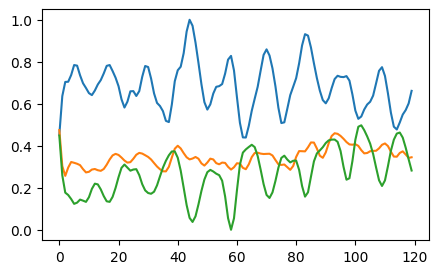

In [35]:
train_dataset = InMemoryDataset(chunks_train, t_max=120, is_squeeze=False, is_unsqueeze=False)
val_dataset = InMemoryDataset(chunks_val, t_max=120, is_squeeze=False, is_unsqueeze=False)
test_dataset = InMemoryDataset(chunks_test, t_max=120, is_squeeze=False, is_unsqueeze=False)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=data_config['batch_size'], num_workers=data_config['num_workers'])
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=data_config['batch_size'], num_workers=data_config['num_workers'])
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=data_config['batch_size'], num_workers=data_config['num_workers'])

print("Train dataset:", len(train_dataset))
print("Val dataset:", len(val_dataset))
print("Test dataset:", len(test_dataset))

print("Train dataloader:", len(train_dataloader))
print("Val dataloader:", len(val_dataloader))
print("Test dataloader:", len(test_dataloader))

print("Train sample shape:", train_dataset[0].shape)
print("Val sample shape:", val_dataset[0].shape)
print("Test sample shape:", test_dataset[0].shape)

print("Train sample type:", train_dataset[0].type())
print("Val sample type:", val_dataset[0].type())
print("Test sample type:", test_dataset[0].type())

plt.figure(figsize=(5,3))
plt.plot(train_dataset[0].squeeze().T)
plt.show()

## Training

### Train/validation function

In [36]:
from IPython.display import clear_output, display

def check_instance(object, types):
    for class_type in types:
        if isinstance(object, class_type):
            return True
    return False

def mask_chunks(chunks, mask_ratio = 0.5):
    B = chunks.shape[0]
    length = chunks.shape[-1]
    mask_length = int(length*mask_ratio)
    max_mask_idx = length - mask_length
    mask_idxs = (max_mask_idx * torch.rand(*list(chunks.shape[:-1]))).type(torch.int)
    
    chunks = chunks.clone().detach()
    chunks_mean = chunks.mean(dim=-1, keepdim=True)
    chunks_std = chunks.std(dim=-1, keepdim=True)
    noise = torch.randn(*chunks.shape[:-1], mask_length)*chunks_std + chunks_mean
    
    if (noise.max() > 1 or noise.min() < 0) and noise.max() - noise.min() != 0:
            noise = (noise - noise.min())/(noise.max() - noise.min()) 
            
    if len(chunks.shape) == 3:
        for chunk, noise_chunk, chunk_mask_idxs in zip(chunks, noise, mask_idxs):
            for ch, noise_ch, ch_mask_idx in zip(chunk, noise_chunk, chunk_mask_idxs):
                ch[ch_mask_idx:ch_mask_idx + mask_length] = noise_ch
                
    elif len(chunks.shape) == 4:
        for chunk, noise_chunk, chunk_mask_idxs in zip(chunks, noise, mask_idxs):
            for ch_d, noise_ch_d, ch_d_mask_idxs in zip(chunk, noise_chunk, chunk_mask_idxs):
                for ch, noise_ch, ch_mask_idx in zip(ch_d, noise_ch_d, ch_d_mask_idxs):
                    ch[ch_mask_idx:ch_mask_idx + mask_length] = noise_ch
        
    else:
        raise ValueError(f"Unexpected number of dimensions in chunks: {len(chunks.shape)}")
                
    return chunks

def train_eval(
    dataloader,
    model,
    device="cuda",
    mode="train",
    optimizer=None,
    test_dataset=None,
    targets_test=None,
    
    step_max=None,
    
    check_period=None,
    plot_period=None,
    epoch=0,
    verbose=0,
    check_steps=None,
    plot_steps=None,
    buffer_max=10,
    logger=None,
    
    ml_model=None,
    ml_param_grid=None, 
    ml_eval_function=None,
    ml_metric_names=None,
    ml_metric_prefix=None,
    plot_type="regression", #"regression"/"classification"
    
    loss_coefs=None,
    
    is_mask=False,
    mask_ratio=0.5,
):
    if mode == "train":
        model.train()
        print("Model is in train mode")
    elif mode == "validation":
        model.eval()
        print("Model is in evaluation mode")
    else:
        print("Unknown mode")
        raise ValueError

    try:
        logger.reset()
        buffer_cnt = 0
        values_keys = []

        for step, imgs in enumerate(dataloader):
            #masking
            if is_mask: imgs_masked = mask_chunks(imgs, mask_ratio=mask_ratio)
            
            #results
            if check_instance(model, [VAE, BetaVAE_H, BetaVAE_B, AE_framework]):
                if is_mask: results = model(imgs_masked.to(device))
                else: results = model(imgs.to(device))
                outputs = results["decoded_imgs"]
            else:
                if is_mask: outputs = model(imgs_masked.to(device))
                else: outputs = model(imgs.to(device))
    
            #Loss parts computation
            sum_dims = tuple(range(1, len(imgs.shape)))
            
            #amplitude
            loss_ampl = ((outputs - imgs.to(device))**2).sum(sum_dims).mean()
    
            #velocity
            outputs_vel = (outputs[:, :, :-1] - outputs[:, :, 1:])
            imgs_vel = (imgs.to(device)[:, :, :-1] - imgs.to(device)[:, :, 1:])
            loss_vel = ((outputs_vel - imgs_vel)**2).sum(sum_dims).mean()
    
            #acceleration
            outputs_acc = (outputs_vel[:, :, :-1] - outputs_vel[:, :, 1:])
            imgs_acc = (imgs_vel[:, :, :-1] - imgs_vel[:, :, 1:])
            loss_acc = ((outputs_acc - imgs_acc)**2).sum(sum_dims).mean()
    
            #frequency
            Foutputs = torch.fft.fft(outputs)
            Foutputs_abs = torch.nn.functional.normalize(torch.abs(outputs), dim=sum_dims[-1])
            Fimgs = torch.fft.fft(imgs.to(device))
            Fimgs_abs = torch.nn.functional.normalize(torch.abs(Fimgs), dim=sum_dims[-1])
            loss_frq = ((Foutputs_abs - Fimgs_abs)**2).sum(sum_dims).mean()
    
            #summation
            if loss_coefs is None: loss_coefs = {"ampl": 1, "vel": 0, "acc": 0, "frq": 0}
            loss_mean = (
                loss_coefs["ampl"]*loss_ampl + 
                loss_coefs["vel"]*loss_vel + 
                loss_coefs["acc"]*loss_acc + 
                loss_coefs["frq"]*loss_frq
            )/np.sum(list(loss_coefs.values()))
            
            if isinstance(model, BetaVAE_B): model.update_global_iter(n=1)

            #learning step
            if mode == "train":
                optimizer.zero_grad()
                loss_mean.backward()
                optimizer.step()
                
            #metrics
            decoded_imgs = outputs.cpu()
            
            ##pearson correlation
            corr_running = 0
            for img, decoded_img in zip(imgs, decoded_imgs): #s * 1 * c * t
                for ch_img, ch_d_img in zip(img.squeeze(), decoded_img.squeeze()):
                    corr_coef = torch.corrcoef(torch.stack([ch_img, ch_d_img]))[0][1]
                    corr_running += corr_coef
            corr_avg = corr_running/torch.prod(torch.tensor(imgs.shape[:-1]))

            ##metric
            err = ((imgs - decoded_imgs)**2).sum(tuple(range(1, len(imgs.shape))))
            max_diff_norm = torch.prod(torch.tensor(imgs.shape[1:])) * 1
            metric = 1 - err / max_diff_norm #in [0, 1]
            
            ##snr
            noise = imgs - decoded_imgs
            signal_power = torch.linalg.vector_norm(imgs, dim=len(imgs.shape)-1)**2
            noise_power = torch.linalg.vector_norm(noise, dim=len(noise.shape)-1)**2
            snr_db = 10*torch.log10(signal_power/noise_power).mean()
            
            #logging 'per step' values
            logger.update({
                'loss': loss_mean.cpu(),
                'metric': metric.mean(),
                'pearson_correlation': corr_avg,
                'snr_db': snr_db,
                'loss_ampl': loss_ampl.cpu(),
                'loss_vel': loss_vel.cpu(),
                'loss_acc': loss_acc.cpu(),
                'loss_frq': loss_frq.cpu()
            })
            
            if check_instance(model, [VAE, BetaVAE_H, BetaVAE_B]):
                for key in ['-log p(x|z)', "kl"]: logger._append(key, results[key])

            #embeddings
            def get_embeddings(model, test_dataset, targets_test):
                if mode == "train": model.eval()
                embeddings_test = model.encode(test_dataset[:].to(device)).detach().cpu().numpy().reshape(len(test_dataset), -1)
                if mode == "train": model.train()

                X = np.array(embeddings_test)
                y = np.array(targets_test)

                if np.any(np.isnan(X)): 
                    nan_indexes = np.where(np.isnan(X))
                    print("Test dataset sample:", test_dataset[nan_indexes[0]], "Embedding:", embeddings_test[nan_indexes[0]])
                    raise ValueError("NaN in embeddings")
                if np.any(np.isnan(y)): 
                    raise ValueError("NaN in targets")

                indices = list(range(len(X)))
                np.random.shuffle(indices)
                return X[indices], y[indices]

            #plotting
            if (plot_period is not None and step % plot_period == 0) or\
            (plot_steps is not None and step in plot_steps):
                if buffer_cnt >= buffer_max:
                    clear_output(wait=True)
                    buffer_cnt = 0
                buffer_cnt += 1

                print(f"Epoch {epoch}, step {step}")

                #pca embeddnigs
                print("Plotting PCA...")
                X, y = get_embeddings(model, test_dataset, targets_test)
                fig, ax = plt.subplots(1, 2, figsize=(12, 3))
                plotData(X, y, method="pca", ax=ax[0], plot_type=plot_type)
                
                #plot reconstruction
                print("Plotting reconstruction...")
                ax[1].plot(imgs[0].squeeze()[0], label="data", color="b", marker="o")
                if mode == "train": model.eval()
                imgs_reconstructed = model.reconstruct(imgs.to(device))
                if mode == "train": model.train()
                ax[1].plot(imgs_reconstructed[0].squeeze()[0].detach().cpu(), label="approximation", color="r")
                plt.show()

            #classifier/regressor metrics evaluation
            if (check_period is not None and step % check_period == 0) or\
            (check_steps is not None and step in check_steps):
                if ml_model is None or ml_param_grid is None or ml_metric_names is None or ml_eval_function is None:
                    raise ValueError("Any of ml parameter is not defined")

                print("Classifier/regressor metrics evaluation...")
                X, y = get_embeddings(model, test_dataset, targets_test)
                results = ml_eval_function(X, y, ml_model, ml_param_grid, verbose=verbose)
                metrics_to_log = {}
                for metric_name in ml_metric_names: metrics_to_log[ml_metric_prefix + metric_name] = results[metric_name]
                logger.update_other(metrics_to_log)

            #break
            if step_max is not None and step >= step_max:
                break

        #logging final results
        logger.average()
        if optimizer is not None: logger._append("lr", optimizer.param_groups[0]['lr'])
        if isinstance(model, BetaVAE_B): logger._append("C", model.get_C())
        logger.log(mode, epoch)
        
        return model, logger.get()

    except KeyboardInterrupt:
        return model, {}

### train

model UNet, 3 ch., 3/3/2/1, 7/7/5/3/3/3/3/1, PReLU is created
optimzer created
scheduler created
Test data point shape: torch.Size([1, 3, 120])
Test inference: 1
Test reconstruct: torch.Size([1, 3, 120])
Test encode: torch.Size([1, 1, 15])
Config: {'model': 'UNet', 'model_config': {'input_dim': torch.Size([3, 120]), 'c1': 3, 'c2': 3, 'c3': 2, 'c_neck': 1}, 'optimizer': 'AdamW', 'optimizer_config': {'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.01, 'amsgrad': False, 'foreach': None, 'maximize': False, 'capturable': False, 'differentiable': False, 'fused': None}, 'scheduler': 'ReduceLROnPlateau', 'scheduler_config': {'factor': 0.5, 'min_lr': 0, 'patience': 3, 'cooldown': 0, 'mode': 'min', 'threshold': 0.0001, 'threshold_mode': 'rel', 'eps': 1e-08}, 'loss_coefs': {'ampl': 1, 'vel': 0, 'acc': 0, 'frq': 0}, 'masking': {'n_masks': 0, 'mask_ratio': 0}, 'start_epoch': 0, 'end_epoch': 1, 'batch_size': 256, 'num_workers': 0, 'samples_shape': (3, 124), 'n_train_samples': 851

  0%|                                                                                                                                    | 0/1 [00:00<?, ?it/s]

Model is in train mode
{'loss': array(174.22134, dtype=float32), 'metric': array(0.51605177, dtype=float32), 'pearson_correlation': array(-0.11434822, dtype=float32), 'snr_db': array(-1.1432693, dtype=float32), 'loss_ampl': array(174.22134, dtype=float32), 'loss_vel': array(19.8675, dtype=float32), 'loss_acc': array(18.981033, dtype=float32), 'loss_frq': array(4.8978105, dtype=float32), 'lr': 0.001}
Model is in evaluation mode
Epoch 0, step 0
Plotting PCA...


,Explained variance,Ratio
0,4.489407e-11,0.999660
1,9.530412e-15,0.000212


Plotting reconstruction...


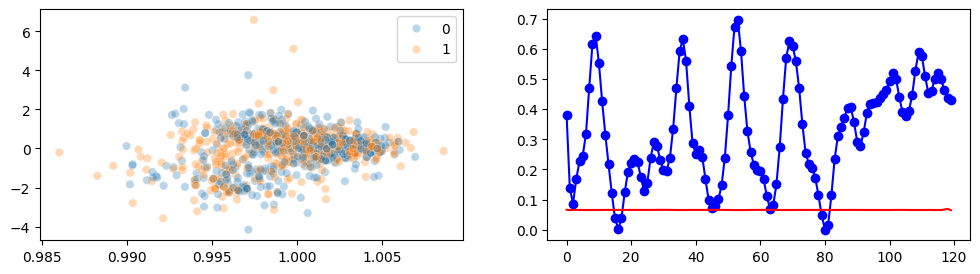

Classifier/regressor metrics evaluation...

Data split

GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Evaluation on the train data
PR AUC, n_sigma=2: 0.582+-0.054


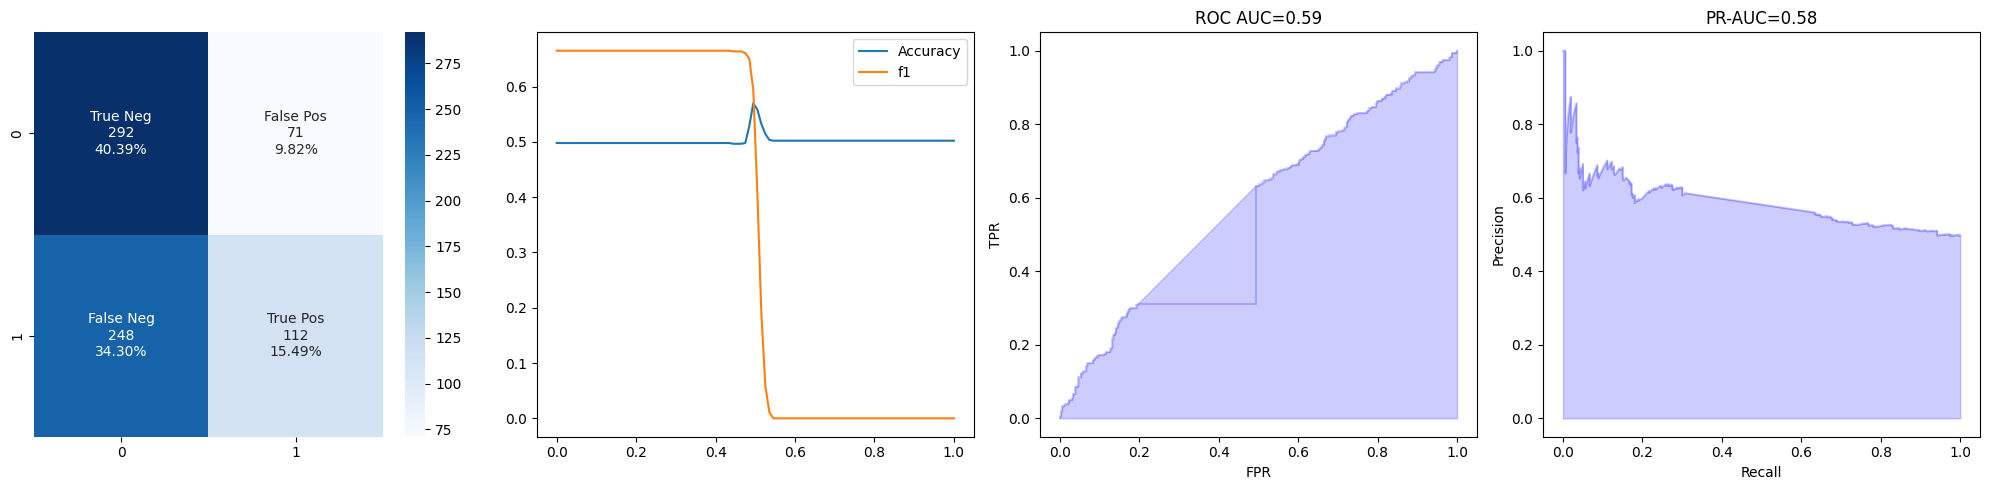


Evaluation on the test data
PR AUC, n_sigma=2: 0.556+-0.075


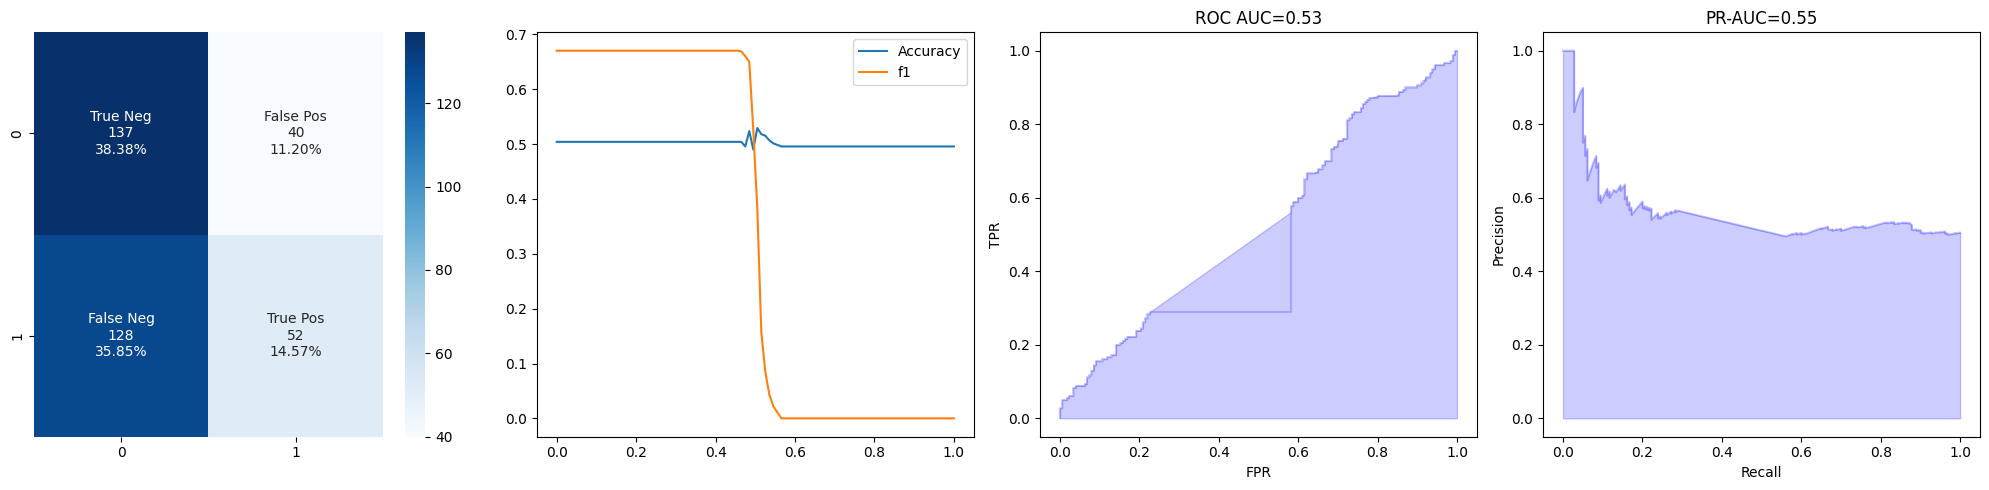

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.01s/it]

{'loss': array(97.80232, dtype=float32), 'metric': array(0.7283269, dtype=float32), 'pearson_correlation': array(-0.08981518, dtype=float32), 'snr_db': array(0.994983, dtype=float32), 'loss_ampl': array(97.80232, dtype=float32), 'loss_vel': array(2.554197, dtype=float32), 'loss_acc': array(2.2579675, dtype=float32), 'loss_frq': array(4.537966, dtype=float32), 'clf_pr_auc_mean_test': 0.5564557960739773, 'clf_pr_auc_mean_train': 0.5823681042287847, 'clf_accuracy_test': 0.5042016806722689, 'clf_accuracy_train': 0.5670816044260027}
New best loss 97.80232238769531 on epoch 0, model was saved


In [37]:
import random
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

## models #######################################################################

###################
## shallow networks
###################

# model_description="beta-VAE, 3 ch., 32/32, 6/6, PReLU"
# model_config = {
#     "latent_dim": 10,
#     "beta": 2,
#     "input_dim": train_dataset[0].shape,
#     "latent_std": 1,
#     "latent_multiplier" : 2
# }
# model = VAE(
#     encoder_conv(model_config),
#     decoder_conv(model_config),
#     **model_config
# ).to(device)

# model_description="0 train, inhouse, beta-VAE-B, 3 ch., 32/32, 6/6, PReLU"
# model_config = {
#     "latent_dim": 10,
#     "beta": 100,
#     "input_dim": train_dataset[0].shape,
#     "latent_std": 1,
#     "C_max": 100,
#     "C_stop_iter": len(train_dataloader)*50,
#     "device": device,
#     "latent_multiplier" : 2
# }
# model = BetaVAE_B(
#     encoder_conv(model_config),
#     decoder_conv(model_config),
#     **model_config
# ).to(device)

# model_description="inhouse, beta-VAE-H, 3 ch., 32/32, 6/6, PReLU"
# model_config = {
#     "latent_dim": 10,
#     "beta": 2,
#     "input_dim": train_dataset[0].shape,
#     "latent_std": 1,
#     "latent_multiplier" : 2
# }
# model = BetaVAE_H(
#     encoder_conv(model_config),
#     decoder_conv(model_config),
#     **model_config
# ).to(device)

# model_description="AE, 3 ch., 32/32, 6/6, PReLU"
# model_config = {
#     "latent_dim": 10,
#     "input_dim": train_dataset[0].shape,
#     "latent_multiplier": 1
# }
# model = AE_framework(
#     encoder_conv(model_config),
#     decoder_conv(model_config),
#     **model_config
# ).to(device)

################
## deep networks
################

# model_description="depr. anon., beta-VAE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid" #!!! CHECK BEFORE TRAINING
# model_config = {
#     "latent_dim": 15*32,
#     "beta": 2,
#     "input_dim": train_dataset[0].shape,
#     "latent_std": 1,
#     "n_channels": 3,
#     "n_classes": 3,
#     "first_decoder_conv_depth": 32
# }
# model = VAE(
#     encoder_conv4(model_config["n_channels"]),
#     decoder_conv4(model_config["n_classes"]),
#     **model_config
# ).to(device)

# model_description="depr. anon., AE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid"
# model_config = {
#     "input_dim": train_dataset[0].shape,
# }
# model = AE(
#     n_channels=train_dataset[0].shape[-2],
#     n_classes=train_dataset[0].shape[-2]
# ).to(device)

model_description="UNet, 3 ch., 3/3/2/1, 7/7/5/3/3/3/3/1, PReLU"
model_config = {
    "input_dim": train_dataset[0].shape,
    "c1": 3,
    "c2": 3,
    "c3": 2,
    "c_neck": 1
}
model = UNet(
    n_channels=train_dataset[0].shape[-2],
    n_classes=train_dataset[0].shape[-2],
    c1=model_config["c1"],
    c2=model_config["c2"],
    c3=model_config["c3"],
    c_neck=model_config["c_neck"],
).to(device)

##################################################################################

## download weights ##############################################################

# run = wandb.init()
# artifact = run.use_artifact('dmitriykornilov_team/EEG_age_prediction/VAE:v13', type='model')
# artifact_dir = artifact.download()
# model.load_state_dict(torch.load(artifact_dir + '/50_epoch.pth'))
# wandb.finish()

##################################################################################

print(f'model {model_description} is created')

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) # instantiate optimizer
print('optimzer created')

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, verbose=True)
print("scheduler created")

# Let's check that forward works
model.eval()
print("Test data point shape:", train_dataset[0][None].shape)
print("Test inference:", len(model(train_dataset[0][None].to(device))))
print("Test reconstruct:", model.reconstruct(train_dataset[0][None].to(device)).shape)
print("Test encode:", model.encode(train_dataset[0][None].to(device)).shape)

def objectName(object):
    return str(type(object)).split(".")[-1].replace("\'>", "")

train_config = {
    "model": objectName(model),
    "model_config": model_config,

    "optimizer": objectName(optimizer),
    "optimizer_config": optimizer.defaults,

    "scheduler": objectName(scheduler),
    "scheduler_config": {
        "factor": scheduler.factor,
        "min_lr": scheduler.min_lrs[0],
        "patience": scheduler.patience,
        "cooldown": scheduler.cooldown,
        "mode": scheduler.mode,
        "threshold": scheduler.threshold,
        "threshold_mode": scheduler.threshold_mode,
        "eps": scheduler.eps
    },
    
    "loss_coefs": {
        "ampl": 1,
        "vel": 0,
        "acc": 0,
        "frq": 0
    },
    "masking" :{
        "n_masks" : 0,
        "mask_ratio" : 0
    },
    
    "start_epoch": 0, # including #!!!CHECK BEFORE TRAINING
    "end_epoch": 1, # excluding #!!!CHECK BEFORE TRAINING
}

project_name = 'EEG_age_prediction'
save_path = OUTPUT_FOLDER + 'models/'
config = {**train_config, **data_config, "method": "direct restoration", "save path": save_path}
print("Config:", config)

logger = Logger(
    log_type="none", #"wandb"/"tensorboard"/"none" #!!!CHECK BEFORE TRAINING
    run_name=model_description,
    save_path=save_path,
    model=model,
    model_name=config["model"],        
    project_name=project_name,
    config=config,
    model_description=model_description,
#         log_dir = OUTPUT_FOLDER + "logs/"
)


#training
best_loss = np.inf
for epoch in tqdm_auto(range(config['start_epoch'], config['end_epoch'])):
    model, results = train_eval(
        train_dataloader,
        model,
        device=device,
        mode="train",
        optimizer=optimizer,
        epoch=epoch,
        logger=logger,
        loss_coefs=train_config["loss_coefs"],
        is_mask=False,
#         mask_ratio=config["masking"]["mask_ratio"],
        step_max=1, #!!!CHECK BEFORE TRAINING
    )
    if results == {}: break
    print(results)

    model, results = train_eval(
        test_dataloader,
        model,
        device=device,
        mode="validation",
        test_dataset=test_dataset,
        targets_test=targets_test,
        check_period=1e10,
        plot_period=1e10,
        epoch=epoch,
        logger=logger,
        loss_coefs=train_config["loss_coefs"],
        is_mask=False,
#         mask_ratio=config["masking"]["mask_ratio"],
        verbose=1,

        ml_model=Pipeline([('scaler', StandardScaler()), ('clf', SVC())]),
        ml_param_grid={
            'clf__kernel': ['linear'],
            'clf__C': np.logspace(-1, 1, 3),
            'clf__probability': [True],
            'clf__class_weight': ['balanced'],
            'clf__random_state': [SEED]
        },
        ml_eval_function=evaluateClassifier,
        ml_metric_names=["pr_auc_mean_test", "pr_auc_mean_train", "accuracy_test", "accuracy_train"],
        ml_metric_prefix="clf_",
        plot_type="classification", #"regression"/"classification"

        # ml_model=Pipeline([('scaler', StandardScaler()), ('reg', Ridge())]),
        # ml_param_grid={
        #     'reg__alpha': np.logspace(-2, 2, 5),
        #     # 'reg__solver': ['sag'],
        #     # 'reg__tol': [1e-4]
        # },
        # ml_eval_function=evaluateRegressor,
        # ml_metric_names=["mse_test", "mse_train"],
        # ml_metric_prefix="reg_",
        # plot_type="regressor", #"regression"/"classification"

        step_max=1, #!!!CHECK BEFORE TRAINING
    )
    if results == {}: break
    print(results)

    scheduler.step(results['loss'])
    
    if results['loss'] < best_loss:
        best_loss = results['loss']
        logger.save_model(epoch)
        print(f"New best loss {best_loss} on epoch {epoch}, model was saved")

logger.save_model(config['end_epoch'])
logger.finish()

# Evaluation

In [38]:
# import pandas as pd

# def to_df(results):
#     return pd.DataFrame(dict([(key, [f"{value:.3f}"]) for key, value in results.items()]))

In [39]:
# model_description="depr. anon., avaf loss, beta-VAE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid" #!!! CHECK BEFORE TRAINING
# model_config = {
#     "latent_dim": 15*32,
#     "beta": 2,
#     "input_dim": train_dataset[0].shape,
#     "latent_std": 1,
#     "n_channels": 3,
#     "n_classes": 3,
# }
# model = VAE(
#     encoder_conv4(model_config["n_channels"]),
#     decoder_conv4(model_config["n_classes"]),
#     **model_config
# ).to(device)

# run = wandb.init()
# artifact = run.use_artifact('dmitriykornilov_team/EEG_age_prediction/VAE:v13', type='model')
# artifact_dir = artifact.download()
# model.load_state_dict(torch.load(artifact_dir + '/49_epoch.pth'))

# logger = Logger(
#     log_type="none", #"wandb"/"tensorboard"/"none"
#     model=model,
# )

# model, results = train_eval(
#     val_dataloader,
#     model,
#     device=device,
#     mode="validation",
#     test_dataset=val_dataset,
#     targets_test=targets_val,
#     check_period=1e10,
#     plot_period=1e10,
#     logger=logger,

#     ml_model=Pipeline([('scaler', StandardScaler()), ('clf', SVC())]),
#     ml_param_grid={
#         'clf__kernel': ['linear'],
#         'clf__C': np.logspace(-2, 2, 5),
#         'clf__probability': [True],
#         'clf__class_weight': [None, 'balanced'],
#         'clf__random_state': [SEED]
#     },
#     ml_eval_function=evaluateClassifier,
#     ml_metric_names=["pr_auc_mean_test", "pr_auc_mean_train", "accuracy_test", "accuracy_train"],
#     ml_metric_prefix="clf_",
#     plot_type="classification", #"regression"/"classification"

#     # ml_model=Pipeline([('scaler', StandardScaler()), ('reg', Ridge())]),
#     # ml_param_grid={
#     #     'reg__alpha': np.logspace(-2, 2, 5),
#     #     # 'reg__solver': ['sag'],
#     #     # 'reg__tol': [1e-4]
#     # },
#     # ml_eval_function=evaluateRegressor,
#     # ml_metric_names=["mse_test", "mse_train"],
#     # ml_metric_prefix="reg_",
#     # plot_type="regressor", #"regression"/"classification"

#     # step_max=2,
# )

# run.finish()

In [40]:
# to_df(results)